# Essential dynamics

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from torch.nn import functional as F
from sklearn.manifold import TSNE

# import sys
# del sys.modules['icl.figures.colors']
# del sys.modules['icl.figures.notation']

from icl.analysis.utils import get_unique_run
from icl.constants import ANALYSIS, FIGURES, SWEEPS
from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN
from icl.constants import DEVICE

MODEL_ID = "Minf1"
LLC_RUN_ID = "tkudtu1b"  # TODO: Actually for m = 14

sns.set_style('white')
DEVICE

plt.rcParams['figure.dpi'] = 300

In [3]:
NUM_TASKS = 'inf'
NUM_LAYERS = 2
MAX_LR = 0.003
MODEL_SEED = 1

# shorthands
BATCH_SIZE = 8192
K = 8
D = 4

run = get_unique_run(
    str(SWEEPS / "training-runs/L2H4Minf-1.yaml"), 
    task_config={"num_tasks": NUM_TASKS, "num_layers": NUM_LAYERS, "model_seed": MODEL_SEED},
    optimizer_config={"lr": MAX_LR}
)

/Users/Jesse/Projects/icl/src/icl/regression/baselines.py:165: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  ws_hat = torch.linalg.solve(LHS, RHS)   # BKDD^-1 @ BKD1 -> B K D 1


In [4]:
from infra.utils.iterables import int_linspace
from copy import deepcopy
from pathlib import Path 

steps = int_linspace(0, 500_000, 50_000)[::10]
# steps

In [5]:
if os.path.exists(Path('../checkpoints') / f"{MODEL_ID}-models.pt"):
    print("Loading models from disk")
    models = torch.load(Path('../checkpoints') / f"{MODEL_ID}-models.pt")
    optimizer_state_dicts = torch.load(Path('../checkpoints') / f"{MODEL_ID}-optimizer_state_dicts.pt")

else:
    print("Retrieving models from AWS")
    # Let's generate these same plots and also look at their evolution. 
    models = []
    optimizer_state_dicts = []

    for step in tqdm.tqdm(steps):
        checkpoint = run.checkpointer.load_file(step)

        m = deepcopy(run.model)
        m.load_state_dict(checkpoint["model"])
        models.append(m)
        optimizer_state_dicts.append(checkpoint["optimizer"])

    print("Saving models to disk")
    torch.save(models, Path('../checkpoints') / f"{MODEL_ID}-models.pt")
    torch.save(optimizer_state_dicts, Path('../checkpoints') / f"{MODEL_ID}-optimizer_state_dicts.pt")

Loading models from disk


In [7]:
import colorsys
from matplotlib.colors import LinearSegmentedColormap

TRANSITIONS = [
    (0, 1500, 'R1'),
    (1500, 40_000, 'R2'),
    #(7_500, 40000, 'R3'),
    (40000, 320000, 'R3'),
    #(120000, 320000, 'R5'),
    (320000, 500000, 'R4'),
]

# def gen_transition_colors(types):
#     """Generates a palette for transition colors. Orange-flavored for Type A. Blue-flavored for Type B."""
#     num_type_a = sum([t == "A" for t in types])
#     num_type_b = sum([t == "B" for t in types])
#     num_other = sum([t == "Other" for t in types])

#     type_a_palette = sns.color_palette("Oranges_r", num_type_a)
#     type_b_palette = sns.color_palette("Blues_r", num_type_b)
#     other_palette = sns.color_palette("Greys_r", num_other)

#     palette = []

#     for t in types:
#         if t == "A":
#             palette.append(type_a_palette.pop())
#         elif t == "B":
#             palette.append(type_b_palette.pop())
#         else:
#             palette.append(other_palette.pop())

#     return palette


def increase_saturation(rgb, saturation_factor):
    # Convert RGB to HSV
    hsv = colorsys.rgb_to_hsv(*rgb)
    
    # Increase saturation by the given factor, making sure it stays in [0, 1]
    new_s = min(max(hsv[1] * saturation_factor, 0), 1)
    
    # Convert back to RGB
    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_s, hsv[2])
    return new_rgb


def increase_contrast(rgb, contrast_factor):
    # Midpoint
    midpoint = 128.0 / 255
    
    # Increase contrast
    new_rgb = [(0.5 + contrast_factor * (component - 0.5)) for component in rgb]
    
    # Clip to the range [0, 1]
    new_rgb = [min(max(component, 0), 1) for component in new_rgb]
    return new_rgb

transition_types = [get_transition_type(t) for t in TRANSITIONS]
transition_colors = gen_transition_colors(transition_types)

transition_colors = [increase_saturation(rgb, 2) for rgb in transition_colors]
transition_colors = [increase_contrast(rgb, 2) for rgb in transition_colors]

transitions_cmap = LinearSegmentedColormap.from_list("transitions", transition_colors)

In [ ]:
from icl.regression.evals import RegressionEvaluator

FORCE_REEVAL = True
BATCH_SIZE = 1024

evaluator = RegressionEvaluator(
    pretrain_dist=run.pretrain_dist,
    true_dist=run.true_dist,
    max_examples=run.config.task_config.max_examples,
    eval_batch_size=BATCH_SIZE,
    seed=run.config.task_config.true_seed,   
)

import pickle


if os.path.exists(ANALYSIS / f"{MODEL_ID}_evals_over_time.pt") and not FORCE_REEVAL:
    print("Loading evals from file")
    evals_over_time_df = torch.load(ANALYSIS / f"{MODEL_ID}_evals_over_time.pt")
else:
    print("Evaluating models")
    evals_over_time = [{**evaluator(model), "step": step, "model_seed": 5} for step, model in zip(steps, tqdm.tqdm(models))]
    evals_over_time_df = pd.DataFrame(evals_over_time)
    with open(ANALYSIS / f"{MODEL_ID}_evals_over_time.pt", 'wb') as f:
        torch.save(evals_over_time_df, f)


evals_over_time_df

In [8]:
import matplotlib.pyplot as plt
import os
from typing import Optional

def get_transition_indices(steps, transitions):
    transition_indices = []
    for step in steps:
        # Find the index of the transition that the current step falls into
        index = next((i for i, transition in enumerate(transitions) if transition[0] <= step < transition[1]), None)
        transition_indices.append(index if index is not None else -1)

    return transition_indices

def get_nearest_step(step):
    idx = np.argmin(np.abs(np.array(steps) - step))
    return steps[idx]

def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None, num_pca_components=None):
    num_pca_components = num_pca_components or len(pca.explained_variance_ratio_)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(num_pca_components), pca.explained_variance_ratio_[:num_pca_components])

    for i, ratio in enumerate(pca.explained_variance_ratio_[:num_pca_components]):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('PC')
    ax.set_ylabel('Explained Variance')

    ax.set_xticks(range(num_pca_components), range(1, num_pca_components + 1))


def plot_multiple_slices(steps, samples, pca, transitions, highlighted_steps=None, connect_dots=False, palette='tab10', alpha=0.8, save=False, line_color="auto"):
    transition_idxs = get_transition_indices(steps, transitions)
    # transition_idxs = [(0 if i != 4 else 1) for i in transition_idxs]

    # for i in range(1, 5):
    #     transition_idxs[-i] = 10  

    if highlighted_steps is None:
        highlighted_steps = list(map(get_nearest_step, [t[0] for t in transitions][1:]))

    num_pca_components = samples.shape[-1]
    
    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components-1)) // 2
    
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=(20, 4))
    # fig.suptitle(title)

    # Ensure ax is iterable by converting to a list if there's only one subplot
    if num_pca_components == 2:
        axes = [axes]

    I = 0
    for i in range(1, num_pca_components):
        for j in range(i):

            if connect_dots:
                axes[I].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            # sc = axes[I].scatter(samples[:, i], samples[:, j], c=transition_idxs, cmap=cmap, s=50, alpha=alpha)
            sns.scatterplot(x=samples[:, i], y=samples[:, j], hue=transition_idxs, palette=palette, s=50, alpha=alpha, ax=axes[I], legend=False)
            axes[I].set_xlabel(f'PC {i}')
            axes[I].set_ylabel(f'PC {j}')
            axes[I].set_title(f'PC {i} vs PC {j}')

            # Label some points
            total_samples = len(samples)
            for step in highlighted_steps:
                k = steps.index(step)  # Find the index of the highlighted step
                axes[I].text(samples[k, i], samples[k, j], str(step), fontsize=8, ha='right', va='bottom', alpha=0.8)

            I += 1

    plot_explained_variance(pca, ax=axes[-1], num_pca_components=num_pca_components)
    # for I in range( num_pca_combos):
    #     axes[I].axis('off')
            
    # Colorbar for the last plot
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as necessary
        # plt.colorbar(sc, cax=cbar_ax, label='Milestones')

    cmap = sns.palettes.color_palette(palette, n_colors=len(transitions) + 1)

    # Plot the legend on the first subplot on the left
    legend_ax = axes[0]
    scatter_proxy = [plt.Line2D([0], [0], linestyle='none', marker='o', alpha=alpha, color=cmap[i]) for i in range(len(transitions))]
    legend_labels = [label for _, _, label in transitions]
    legend_ax.legend(scatter_proxy, legend_labels, loc='center', ncol=1, frameon=False, bbox_to_anchor=(-0.5, 0.5), title='Developmental Stages')
    # legend_ax.set_title()

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right side to make room for the colorbar

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


    fig.set_facecolor('white')
    
# Usage of the function
# Call the function with your data and the list of highlighted steps
# plot_multiple_slices(steps, samples, pca, highlighted_steps=[100, 1000, 10000], title="Your Title", num_points_to_label=10, save="path/to/save.png", connect_dots=True)

In [9]:
# Do the PCAs again. 
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from icl.analysis.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.regression.train import Run
from infra.utils.tensors import convert_tensor, ReturnTensor
from matplotlib import colors as mcolors


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        model.to(DEVICE)
        xs.to(model.device)
        ys.to(model.device)
        hooked_model = hook(model, *paths)
        outputs, activations = hooked_model.run_with_cache(xs, ys)
        activations[""] = outputs
        return {k: convert_tensor(v, return_type) for k, v in activations.items() if (k in paths or k == "") and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, normalize=False):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            if normalize:
                activation = activation / np.linalg.norm(activation)

            evals[path].append(activation)

    return {
        k: np.array(v) for k, v in evals.items()
    }

def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3, normalize=False) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in tqdm.tqdm(get_vectorized_activations_trace(models, xs, ys, *paths, normalize=normalize).items(), total=len(models)):
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results

In [10]:
all_outputs = []
only_xs = []
only_ys = []
all_gradients = []

all_running_grads = []
all_running_grads_squared = []


def get_exp_avg_sq_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg_sq"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])

def get_exp_avg_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


# Outputs of token sequence transformer
outputs = []
only_x_outputs = []
only_y_preds = []

xs, ys, ws = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, run.evaluator.pretrain_ws

activations_trace = get_vectorized_activations_trace(tqdm.tqdm(models), xs, ys, 'token_sequence_transformer', normalize=False)
print({k: v.shape for k, v in activations_trace.items()})

activations = activations_trace['token_sequence_transformer']
vec_activations = activations.reshape(len(activations), -1)
outputs.append(vec_activations)
print(activations.shape)
only_x_outputs.append(activations[:, :, ::2, :].reshape(len(vec_activations), -1))

y_preds = activations_trace[""]
only_y_preds.append(y_preds.reshape(len(y_preds), -1))

all_outputs.append(np.concatenate(outputs, axis=1))
only_xs.append(np.concatenate(only_x_outputs, axis=1))
only_ys.append(np.concatenate(only_y_preds, axis=1))


100%|██████████| 5000/5000 [00:39<00:00, 125.86it/s]


{'token_sequence_transformer': (5000, 1024, 16, 5), '': (5000, 1024, 8, 1)}
(5000, 1024, 16, 5)


In [11]:
from icl.constants import DATA

with open(DATA / f"{MODEL_ID}_xs_ys_ws.pt", 'wb') as f:
    torch.save((xs, ys, ws), f)

In [12]:
# all_weights = []

# # Weights & Gradients
# gradients = []
weights = []

def get_weights_vector(model):
    return np.concatenate([param.detach().cpu().numpy().flatten() for name, param in model.named_parameters() if param is not None])

def get_gradients_vector(model):
    return np.concatenate([param.grad.detach().cpu().numpy().flatten() for name, param in model.named_parameters() if param.grad is not None])

for model in tqdm.tqdm(models[::20]):
    # model.to(DEVICE)
    # train_xs_1.to(DEVICE)
    # train_ys_1.to(DEVICE)
    # model.train()
    # model.zero_grad()
    # train_ys_1_pred = model(train_xs_1, train_ys_1)
    # loss = F.mse_loss(train_ys_1_pred, train_ys_1)
    # loss.backward()

    # gradients.append(get_gradients_vector(model))
    weights.append(get_weights_vector(model))

# all_gradients.append(np.array(gradients))
all_weights = np.array(weights)

# # Optimizer states
# running_grads = []
# running_grads_squared = []
# for opt_state_dict in opt_state_dicts:
#     running_grads.append(get_exp_avg_grads(opt_state_dict))
#     running_grads_squared.append(get_exp_avg_sq_grads(opt_state_dict))

# all_running_grads.append(np.array(running_grads))
# all_running_grads_squared.append(np.array(running_grads_squared))

100%|██████████| 250/250 [00:01<00:00, 186.06it/s]


In [13]:
import pickle


def plot_essential_dynamics_grid(steps, all_samples, transitions, palette='tab10', save=False, figsize=(20, 4), num_pca_components=3, max_step=None, normalize=False, labels=None, special=[]):
    num_samples = len(all_samples)  

    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components-1)) // 2
    fig, all_axes = plt.subplots(num_samples, num_pca_combos + 1, figsize=figsize)
    
    if num_samples == 1:
        all_axes = [all_axes]

    labels = labels or [f"Model {i+1}" for i in range(num_samples)]

    for samples_idx, _samples in enumerate(tqdm.tqdm(all_samples, desc="Plotting...")):
        if max_step is not None:
            max_step_idx = steps.index(max_step)
            _samples = _samples[:max_step_idx, :]
        if normalize:
            _samples = _samples / np.linalg.norm(_samples, axis=1, keepdims=True)

        pca = PCA(n_components=10 * num_pca_components)
        samples = pca.fit_transform(_samples)   

        axes = all_axes[samples_idx]

        # Ensure ax is iterable by converting to a list if there's only one subplot
        if num_pca_components == 2:
            axes = [axes]

        special_transforms = [
            pca.transform(s) for s, _ in special
        ]

        I = 0
        for i in range(1, num_pca_components):
            for j in range(i):
                sns.scatterplot(x=samples[:, i], y=samples[:, j], ax=axes[I], alpha=0.5, color="gray", s=10, legend=False)
                for k, (start, end, stage) in enumerate(transitions):
                    start_idx = steps.index(start)
                    end_idx = steps.index(end) + 1
                        
                    # sc = axes[I].scatter(samples[:, i], samples[:, j], c=transition_idxs, cmap=cmap, s=50, alpha=alpha)
                    axes[I].plot(samples[start_idx:end_idx, i], samples[start_idx:end_idx, j])

                for s, (_, settings) in zip(special_transforms, special):
                    style = settings.get("style", 'r+')
                    axes[I].plot(s[:, i], s[:, j], style)

                if not transitions:
                    axes[I].plot(samples[:, i], samples[:, j])

                axes[I].set_xlabel(f'PC {i+1}')
                axes[I].set_ylabel(f'PC {j+1}')
                axes[I].set_title(f'PC {j+1} vs PC {i+1}')

                I += 1

        axes[0].set_ylabel(f"{labels[samples_idx]}\n\nPC 1")

        plot_explained_variance(pca, ax=axes[-1], num_pca_components=num_pca_components)

    # cmap = sns.palettes.color_palette(palette, n_colors=len(transitions) + 1)
    # Plot the legend on the first subplot on the left
    # legend_ax = axes[0]
    # scatter_proxy = [plt.Line2D([0], [0], linestyle='none', marker='o', alpha=alpha, color=cmap[i]) for i in range(len(transitions))]
    # legend_labels = [label for _, _, label in transitions]
    # legend_ax.legend(scatter_proxy, legend_labels, loc='center', ncol=1, frameon=False, bbox_to_anchor=(-0.5, 0.5), title='Developmental Stages')
    # legend_ax.set_title()

    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right side to make room for the colorbar
    plt.tight_layout(rect=[0, 0, 1, 1])

    if transitions:
        # Create an axis for the legend
        legend_ax = fig.add_axes([0.1, -0.03, 0.95, 0.05])  # Adjust these values as needed

        # Create a list of handles for the legend
        handles = [plt.Line2D([0], [0], color=sns.color_palette(palette)[i], linestyle='-') for i in range(len(transitions))]
        labels = [label for _, _, label in transitions]

        # Add legend to the new axis
        legend_ax.legend(handles, labels, loc='center', ncol=len(labels), frameon=False)
        legend_ax.axis('off')  # Turn off axis lines and labels

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        with open(save + ".pkl", "wb") as f:
            pickle.dump((pca, samples), f)

        plt.savefig(save + ".png")

    fig.set_facecolor('white')

    return fig

In [14]:
CLOSEST_TRANSITIONS = [
    (get_nearest_step(t0), get_nearest_step(t1), label) for t0, t1, label in TRANSITIONS
]
print(CLOSEST_TRANSITIONS)
steps[10], steps[100], steps[500], steps[1000]

[(0, 1500, 'R1'), (1500, 40000, 'R2'), (40000, 320006, 'R3'), (320006, 499909, 'R4')]


(1000, 10000, 50001, 100002)

In [16]:
all_outputs[0].shape, only_x_outputs[0].shape, 

((5000, 81920), (5000, 40960))

In [17]:
with open("../data/ED-proxy.pkl", "wb") as f:
    pickle.dump(all_outputs, f)

[(0, 900, 'A')]
[(0, 1500, 'R1'), (1200, 10000, 'B')]


Plotting...: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
<ipython-input-20-48eec2575a13>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-20-48eec2575a13>:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


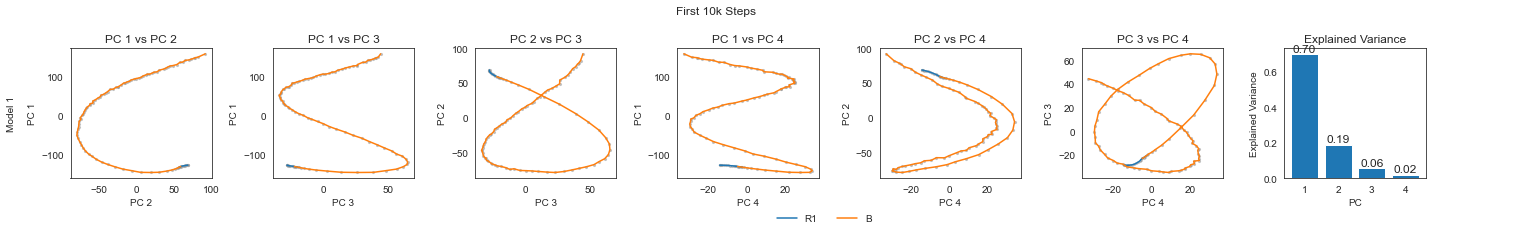

[(0, 1500, 'R1'), (1500, 40000, 'R2'), (40000, 320006, 'R3'), (60001, 100002, 'D')]


Plotting...: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]
<ipython-input-20-48eec2575a13>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-20-48eec2575a13>:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


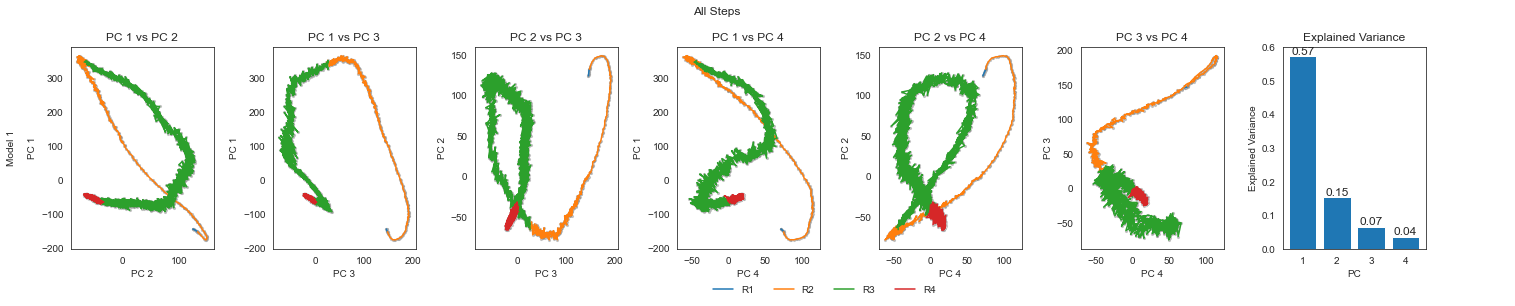

In [20]:
save= "../data/LMinf1-behavioral-ED"

# _all_outputs = only_ys # 
_all_outputs = [all_outputs[0][:, ]] 

# zero_prediction = np.zeros_like(_all_outputs[0][0:1])
special = [
    # (zero_prediction, {"title": "Task prior"}),
    # (first_xs.detach().cpu().numpy(), {"title": "First x", "style": "b+"}),           
    # (prev_xs.detach().cpu().numpy(), {"title": "Previous x", "style": "g+"}),
    # (cumulative_xs.detach().cpu().numpy(), {"title": "Cumulative x", "style": "o+"}),
]

truncated_transitions = CLOSEST_TRANSITIONS[:1]
truncated_transitions[-1] = (0, steps[10-1], 'A')
print(truncated_transitions)

# fig = plot_essential_dynamics_grid(steps[:10], [_all_outputs[0][:10]], truncated_transitions, num_pca_components=4, figsize=(20, 3), special=special)        
# fig.suptitle("First 1k Steps")
# plt.tight_layout()
# plt.show()

# s = 30
# truncated_transitions = CLOSEST_TRANSITIONS[:2]
# truncated_transitions[-1] = (1200, steps[s-1], 'B')
# print(truncated_transitions)

# fig = plot_essential_dynamics_grid(steps[:s], [_all_outputs[0][:s]], truncated_transitions, num_pca_components=4, figsize=(20, 3), special=special)        
# fig.suptitle(f"First {int(s//10)}k Steps")
# plt.tight_layout()
# plt.show()

truncated_transitions = CLOSEST_TRANSITIONS[:2]

truncated_transitions[-1] = (1200, steps[100], 'B')
print(truncated_transitions)

fig = plot_essential_dynamics_grid(steps[:101], [_all_outputs[0][:101]], truncated_transitions, num_pca_components=4, figsize=(20, 3), special=special)        
fig.suptitle("First 10k Steps")
plt.tight_layout()
plt.show()

truncated_transitions = CLOSEST_TRANSITIONS[:4]
truncated_transitions[-1] = (60001, steps[1000], 'D')
print(truncated_transitions)

# fig = plot_essential_dynamics_grid(steps[:1001], [_all_outputs[0][:1001]], truncated_transitions, num_pca_components=4, figsize=(20, 3), special=special)        
# fig.suptitle("First 100k Steps")
# plt.tight_layout()
# plt.show()

fig = plot_essential_dynamics_grid(
    steps, _all_outputs, CLOSEST_TRANSITIONS, num_pca_components=4, figsize=(20, 4), 
    special=special, 
    save=save
)        
fig.suptitle("All Steps")
plt.tight_layout() 
plt.show()
# plot_multiple_slices(
#     steps[:MAX_PCA_STEP], 
#     exp_avg_grads_reduced[:, :3], 
#     pca_1, 
#     TRANSITIONS[:4],
#     connect_dots=True, 
#     save=None,
#     # cmap=transitions_cmap
# )
# plt.suptitle("Essential Dynamics of Exponentially Averaged Square Gradients")
# plt.tight_layout()
# plt.show()


Plotting...: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
<ipython-input-21-298a4c5568d0>:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-21-298a4c5568d0>:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


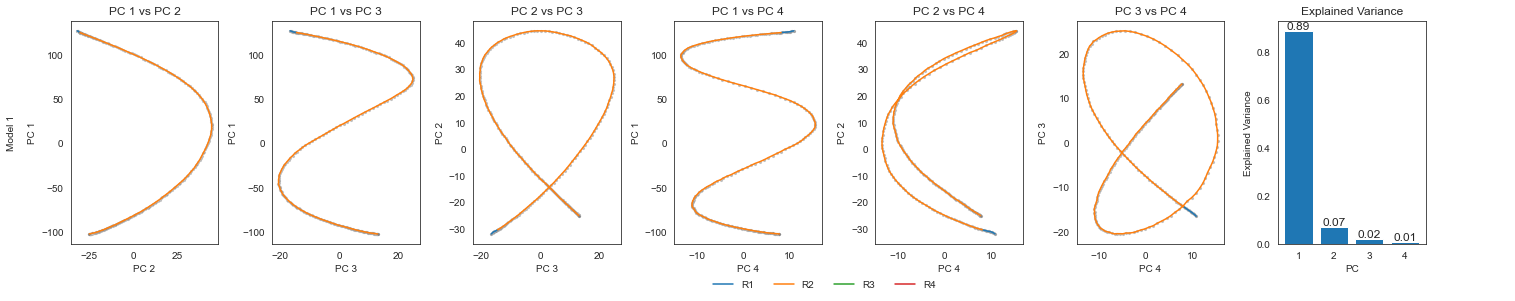

In [21]:
fig = plot_essential_dynamics_grid(
    steps, [all_weights], CLOSEST_TRANSITIONS, num_pca_components=4, figsize=(20, 4), 
    special=special, 
    save="../data/Minf1-ED-weight"
)        
# fig.suptitle("All Steps")
plt.tight_layout() 